## Test Predizione Traiettoria Navi LNN (senza nessun attacco)

In [1]:
import os

os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib

from ncps.tf import CfC
from ncps.wirings import AutoNCP
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, TimeDistributed, RepeatVector

import gc
from collections import Counter
import pyarrow.parquet as pq
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Configurazione GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# COSTANTI
WINDOW_SIZE = 30
BATCH_SIZE = 2048
COLONNE_FEATURES = ['Latitude', 'Longitude', 'SOG', 'COG']
INPUT_DIR = '../Pre-Elaborazione Dati/Dataset'
SCALER_PATH = 'scaler.joblib'
WEIGHTS_PATH = 'lnn_autoencoder_best.weights.h5'

# Parametri LNN
RECURRENT_UNITS = 128
BOTTLENECK_SIZE = 64

print("Configurazione completata.")

Configurazione completata.


In [2]:
if os.path.exists(SCALER_PATH):
    scaler = joblib.load(SCALER_PATH)
    print(f"Scaler caricato: {SCALER_PATH}")
else:
    raise FileNotFoundError("Errore: Scaler non trovato.")

all_files = sorted(glob.glob(os.path.join(INPUT_DIR, '*.parquet')))
TEST_FILES = all_files[20:24]

print(f"File totali trovati: {len(all_files)}")
print(f"File selezionati per il TEST: {len(TEST_FILES)}")
print(TEST_FILES)

Scaler caricato: scaler.joblib
File totali trovati: 25
File selezionati per il TEST: 4
['../Pre-Elaborazione Dati/Dataset/blocco_020-segmentato.parquet', '../Pre-Elaborazione Dati/Dataset/blocco_021-segmentato.parquet', '../Pre-Elaborazione Dati/Dataset/blocco_022-segmentato.parquet', '../Pre-Elaborazione Dati/Dataset/blocco_023-segmentato.parquet']


In [3]:
def calculate_steps_per_epoch(file_paths, window_size, batch_size):
    """
    Scansiona tutti i file in modo efficiente (RAM-safe) per calcolare
    il numero totale di finestre (campioni) che verranno generate,
    e da lì calcola il numero di "steps" (batch) per epoca.
    Usa il metodo Counter.update(Series) che sappiamo funzionare.
    """
    print(f"Calcolo Steps per {len(file_paths)} file")
    
    total_lengths = Counter()
    
    #Trova le lunghezze di tutte le 4.3M traiettorie
    for i, file_path in enumerate(file_paths):
        print(f"  Scansione lunghezze file {i+1}/{len(file_paths)}...", end='\r')
        try:
            df = pd.read_parquet(file_path, columns=['TrajectoryID'])
            total_lengths.update(df['TrajectoryID'])
            del df
            gc.collect()
        except Exception as e:
            print(f"Errore nel leggere {file_path}: {e}")

    print("\nScansione completata.")

    #Calcola il numero totale di finestre
    total_windows = 0
    for length in total_lengths.values():
        if length >= window_size:
            total_windows += (length - window_size + 1)
            
    #Calcola gli steps
    steps = int(np.ceil(total_windows / batch_size))
    
    print(f"Trovate {total_windows:,} finestre totali.")
    print(f"Steps per Epoca (Batch Size {batch_size}): {steps}")
    print("-" * 75)
    return steps


def create_windows(data_np, window_size):
    windows = []
    for i in range(len(data_np) - window_size + 1):
        windows.append(data_np[i : i + window_size])
    return windows

def data_generator_v(file_paths, scaler, features, window_size, batch_size, shuffle_files=False):
    
    file_buffer = {} 
    window_buffer = [] 
    CHUNK_SIZE_ROWS = 500_000

    while True:
        if shuffle_files:
             # Shuffle disattivato forzatamente per garantire la sequenzialità
            shuffle_files = False 
            
        for file_path in file_paths:
            chunk_buffer = {}
            try:
                pf = pq.ParquetFile(file_path)
                for batch in pf.iter_batches(batch_size=CHUNK_SIZE_ROWS, columns=features + ['TrajectoryID']):
                    df_chunk = batch.to_pandas()
                    df_chunk[features] = scaler.transform(df_chunk[features])
                    next_chunk_buffer = {}
                    
                    for tid, group in df_chunk.groupby('TrajectoryID'):
                        if tid in chunk_buffer:
                            trajectory_data = pd.concat([chunk_buffer.pop(tid), group])
                        else:
                            trajectory_data = group
                        
                        if tid in file_buffer:
                            trajectory_data = pd.concat([file_buffer.pop(tid), trajectory_data])
                        
                        # Se la traiettoria tocca la fine del chunk, bufferizzala
                        if trajectory_data.iloc[-1].name == df_chunk.iloc[-1].name:
                            next_chunk_buffer[tid] = trajectory_data
                            continue 
                            
                        if len(trajectory_data) < window_size:
                            continue 
                            
                        trajectory_np = trajectory_data[features].to_numpy()
                        new_windows = create_windows(trajectory_np, window_size)
                        window_buffer.extend(new_windows)
                        
                        next_chunk_buffer[tid] = trajectory_data.iloc[-(window_size - 1):]

                        while len(window_buffer) >= batch_size:
                            batch_to_yield = window_buffer[:batch_size]
                            window_buffer = window_buffer[batch_size:]
                            yield (np.array(batch_to_yield), np.array(batch_to_yield))
                    
                    chunk_buffer = next_chunk_buffer
                file_buffer = chunk_buffer
            except Exception as e:
                print(f"\nErrore lettura {file_path}: {e}")
                continue
print("Funzioni definite")

Funzioni definite


In [4]:
n_features = len(COLONNE_FEATURES)

# Wiring
wiring = AutoNCP(RECURRENT_UNITS, output_size=BOTTLENECK_SIZE)

# Definizione Layer
inputs = Input(shape=(WINDOW_SIZE, n_features))
lnn_encoder = CfC(wiring, return_sequences=False, mixed_memory=True)(inputs)
repeat_vector = RepeatVector(WINDOW_SIZE)(lnn_encoder)
lnn_decoder = CfC(wiring, return_sequences=True, mixed_memory=True)(repeat_vector)
output = TimeDistributed(Dense(n_features))(lnn_decoder)

model = Model(inputs, output)

model.compile(optimizer='adam', loss='mae')

# Caricamento Pesi
if os.path.exists(WEIGHTS_PATH):
    print(f"Caricamento pesi da: {WEIGHTS_PATH}")
    model.load_weights(WEIGHTS_PATH)
    print("Modello LNN caricato e pronto.")
else:
    raise FileNotFoundError(f"File pesi non trovato: {WEIGHTS_PATH}")

I0000 00:00:1764187136.297181  101004 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4130 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Caricamento pesi da: lnn_autoencoder_best.weights.h5
Modello LNN caricato e pronto.


In [5]:
print("Calcolo step totali")
test_steps = calculate_steps_per_epoch(TEST_FILES, WINDOW_SIZE, BATCH_SIZE)
print(f"Steps totali per il test: {test_steps}")

# Generatore
test_gen = data_generator_v(
    file_paths=TEST_FILES,
    scaler=scaler,
    features=COLONNE_FEATURES,
    window_size=WINDOW_SIZE,
    batch_size=BATCH_SIZE,
    shuffle_files=False
)


print(f"\nAvvio Valutazione su {len(TEST_FILES)} file")
test_loss = model.evaluate(test_gen, steps=test_steps, verbose=1)

print("-" * 30)
print(f"RISULTATO FINALE LNN:")
print(f"Mean Absolute Error (MAE): {test_loss:.5f}")
print("-" * 30)

Calcolo step totali
Calcolo Steps per 4 file
  Scansione lunghezze file 4/4...
Scansione completata.
Trovate 110,429,714 finestre totali.
Steps per Epoca (Batch Size 2048): 53921
---------------------------------------------------------------------------
Steps totali per il test: 53921

Avvio Valutazione su 4 file
53921/53921 [==============================] - 1501s 28ms/step - loss: 0.0158
------------------------------
RISULTATO FINALE LNN:
Mean Absolute Error (MAE): 0.01585
------------------------------


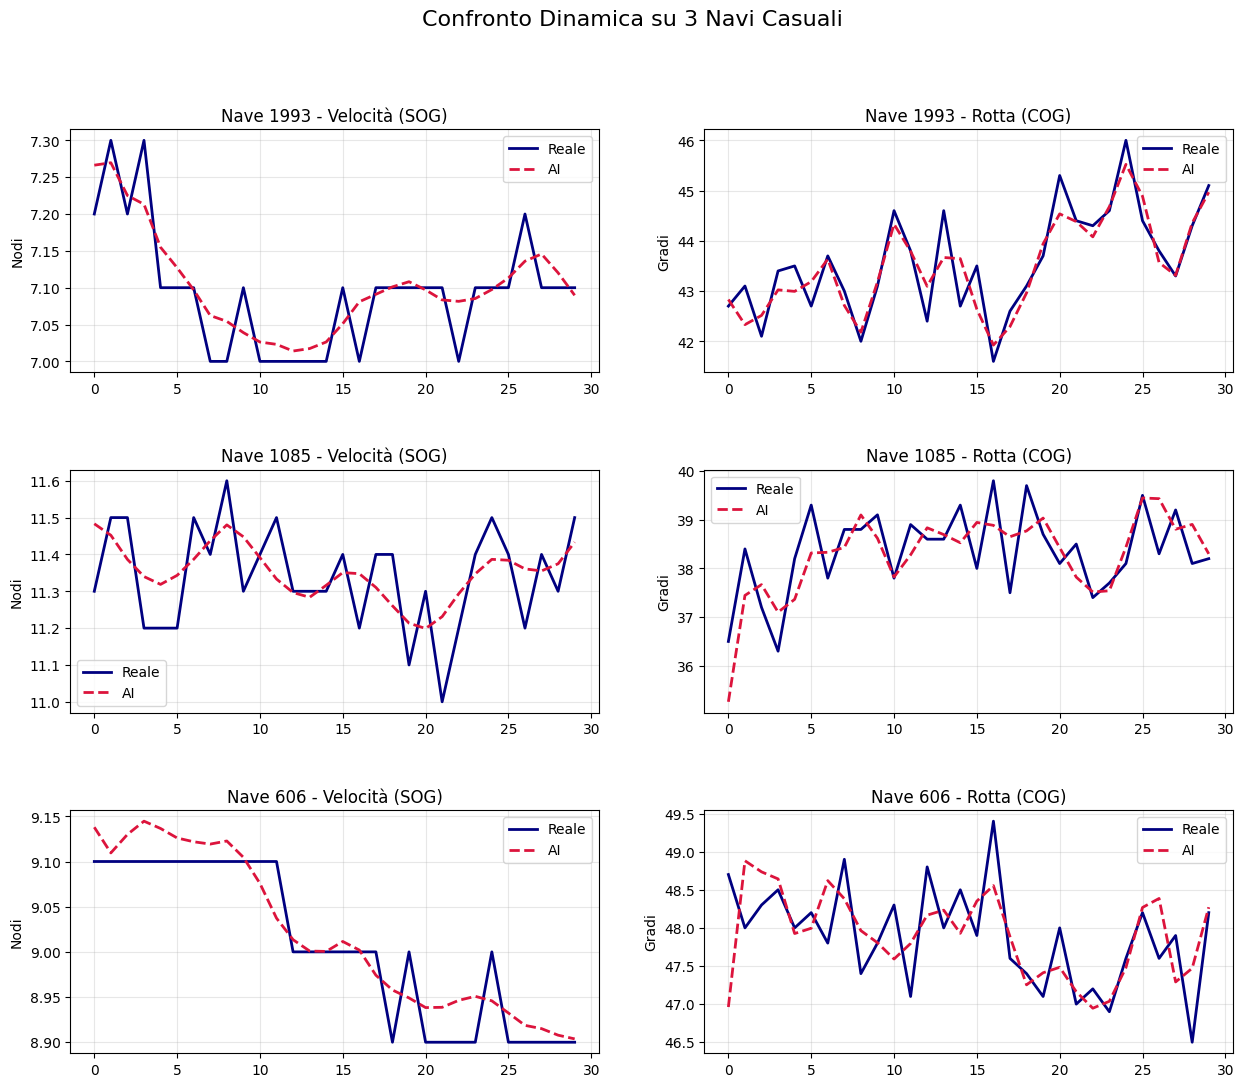

In [5]:
# Batch di dati
test_gen = data_generator_v(
    file_paths=TEST_FILES,
    scaler=scaler,
    features=COLONNE_FEATURES,
    window_size=WINDOW_SIZE,
    batch_size=BATCH_SIZE,
    shuffle_files=False
)

X_batch, _ = next(test_gen)
pred_batch = model.predict(X_batch, verbose=0)

# Denormalizza tutto subito (per avere nodi e gradi)
sh = X_batch.shape
X_real = scaler.inverse_transform(X_batch.reshape(-1, sh[2])).reshape(sh)
P_real = scaler.inverse_transform(pred_batch.reshape(-1, sh[2])).reshape(sh)

# Scegliamo 3 navi a caso dal batch da mostrare
num_esempi = 3
indices = random.sample(range(len(X_real)), num_esempi)

# Plot
fig, axes = plt.subplots(nrows=num_esempi, ncols=2, figsize=(15, 4 * num_esempi))
plt.subplots_adjust(hspace=0.4)

for i, idx in enumerate(indices):
    # Dati della nave corrente
    real = X_real[idx]
    pred = P_real[idx]
    
    # Colonna 1: Velocità (SOG) - Indice 2
    axes[i, 0].plot(real[:, 2], label='Reale', color='navy', linewidth=2)
    axes[i, 0].plot(pred[:, 2], label='AI', color='crimson', linestyle='--', linewidth=2)
    axes[i, 0].set_title(f"Nave {idx} - Velocità (SOG)")
    axes[i, 0].set_ylabel("Nodi")
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)
    
    # Colonna 2: Rotta (COG) - Indice 3
    axes[i, 1].plot(real[:, 3], label='Reale', color='navy', linewidth=2)
    axes[i, 1].plot(pred[:, 3], label='AI', color='crimson', linestyle='--', linewidth=2)
    axes[i, 1].set_title(f"Nave {idx} - Rotta (COG)")
    axes[i, 1].set_ylabel("Gradi")
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)

plt.suptitle(f"Confronto Dinamica su {num_esempi} Navi Casuali", fontsize=16)
plt.show()

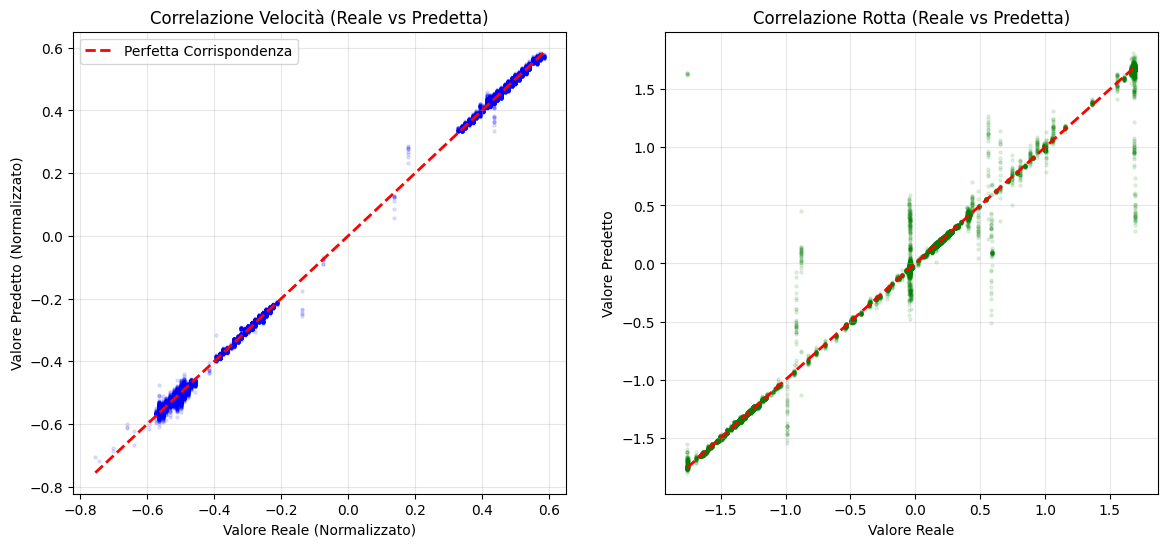

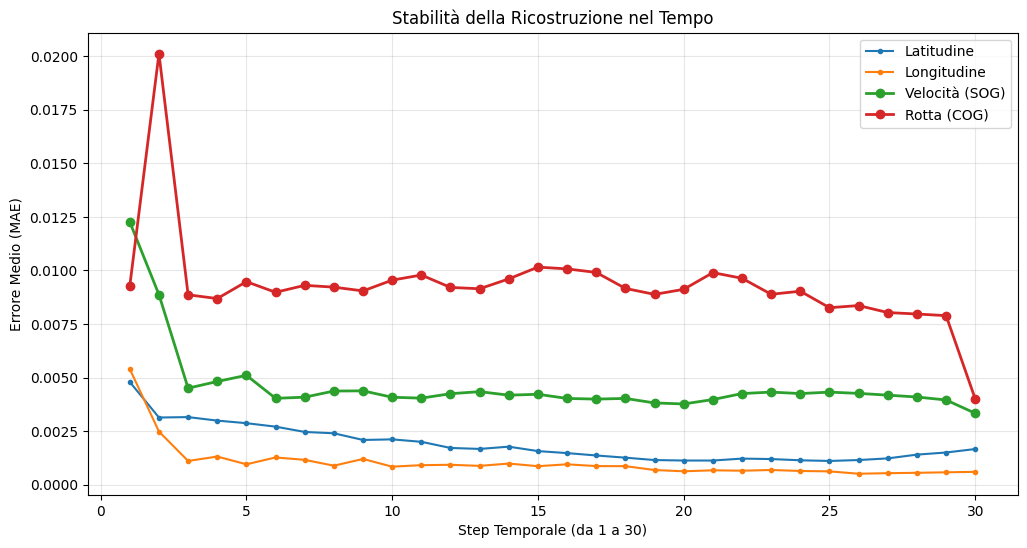

In [6]:
X_test_batch, _ = next(test_gen)
X_pred_batch = model.predict(X_test_batch, verbose=0)

plt.figure(figsize=(14, 6))

# Plot per la Velocità (SOG)
plt.subplot(1, 2, 1)

y_true = X_test_batch[:, :, 2].flatten() # Indice 2 = SOG
y_pred = X_pred_batch[:, :, 2].flatten()

plt.scatter(y_true, y_pred, alpha=0.1, s=5, color='blue')
# Disegniamo la diagonale perfetta (Idealmente y=x)
min_val, max_val = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfetta Corrispondenza')

plt.title("Correlazione Velocità (Reale vs Predetta)")
plt.xlabel("Valore Reale (Normalizzato)")
plt.ylabel("Valore Predetto (Normalizzato)")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot per la Rotta (COG)
plt.subplot(1, 2, 2)
y_true_cog = X_test_batch[:, :, 3].flatten() # Indice 3 = COG
y_pred_cog = X_pred_batch[:, :, 3].flatten()

plt.scatter(y_true_cog, y_pred_cog, alpha=0.1, s=5, color='green')
plt.plot([min(y_true_cog), max(y_true_cog)], [min(y_true_cog), max(y_true_cog)], 'r--', linewidth=2)

plt.title("Correlazione Rotta (Reale vs Predetta)")
plt.xlabel("Valore Reale")
plt.ylabel("Valore Predetto")
plt.grid(True, alpha=0.3)

plt.show()


mae_per_step = np.mean(np.abs(X_test_batch - X_pred_batch), axis=0)

plt.figure(figsize=(12, 6))
steps = range(1, WINDOW_SIZE + 1)

plt.plot(steps, mae_per_step[:, 0], label='Latitudine', marker='.')
plt.plot(steps, mae_per_step[:, 1], label='Longitudine', marker='.')
plt.plot(steps, mae_per_step[:, 2], label='Velocità (SOG)', marker='o', linewidth=2)
plt.plot(steps, mae_per_step[:, 3], label='Rotta (COG)', marker='o', linewidth=2)

plt.title("Stabilità della Ricostruzione nel Tempo")
plt.xlabel("Step Temporale (da 1 a 30)")
plt.ylabel("Errore Medio (MAE)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

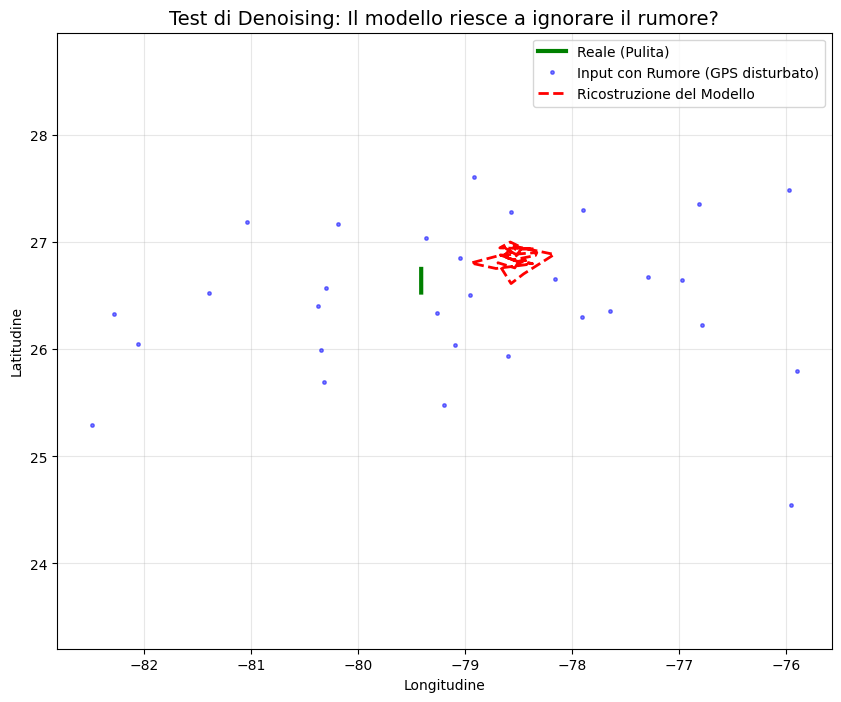

In [10]:
# Prendiamo una traiettoria pulita
idx_robust = 0
clean_traj = X_batch_latent[idx_robust]

# Aggiungiamo rumore artificiale
noise = np.random.normal(0, 0.1, clean_traj.shape) # Rumore gaussiano
noisy_traj = clean_traj + noise

# Chiediamo al modello di ricostruire quella RUMOROSA
# (Nota: il modello non ha mai visto questo rumore in addestramento!)
pred_from_noisy = model.predict(noisy_traj.reshape(1, WINDOW_SIZE, 4), verbose=0)[0]

clean_phys = scaler.inverse_transform(clean_traj)
noisy_phys = scaler.inverse_transform(noisy_traj)
pred_phys = scaler.inverse_transform(pred_from_noisy)

plt.figure(figsize=(10, 8))
plt.plot(clean_phys[:, 1], clean_phys[:, 0], 'g-', linewidth=3, label='Reale (Pulita)')
plt.plot(noisy_phys[:, 1], noisy_phys[:, 0], 'b.', markersize=5, alpha=0.5, label='Input con Rumore (GPS disturbato)')
plt.plot(pred_phys[:, 1], pred_phys[:, 0], 'r--', linewidth=2, label='Ricostruzione del Modello')

plt.title("Test di Denoising: Il modello riesce a ignorare il rumore?", fontsize=14)
plt.xlabel("Longitudine")
plt.ylabel("Latitudine")
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

🚀 Avvio Test 'Spirale Temporale'...
🔍 Scansione dataset per trovare una virata netta...
✅ Traiettoria curva trovata.


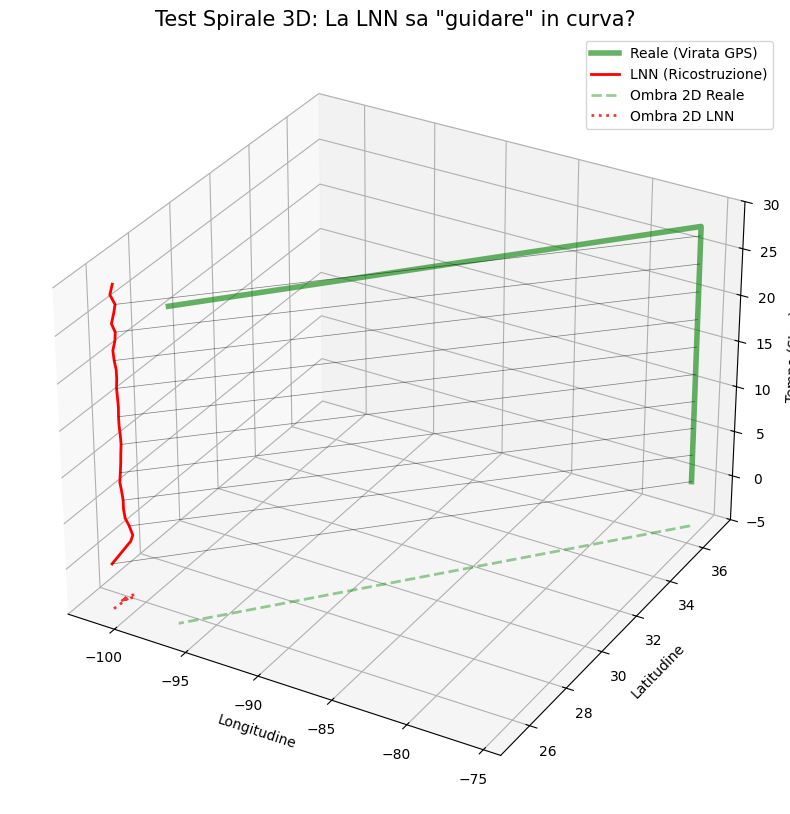

In [ ]:
import matplotlib.pyplot as plt

# --- VISUALIZZAZIONE 2D PULITA (DALL'ALTO) ---

plt.figure(figsize=(10, 10))

# 1. Disegniamo la rotta Reale (Verde)
plt.plot(real_phys[:, 1], real_phys[:, 0], 
         color='green', linewidth=4, alpha=0.5, label='Reale (GPS)')

# Mettiamo dei pallini per far vedere i passi
plt.scatter(real_phys[:, 1], real_phys[:, 0], color='green', s=30, alpha=0.5)

# 2. Disegniamo la LNN (Rosso)
plt.plot(recon_phys[:, 1], recon_phys[:, 0], 
         color='red', linewidth=2, linestyle='-', label='LNN (Predizione)')

# Mettiamo delle X per far vedere dove la LNN pensa di essere
plt.scatter(recon_phys[:, 1], recon_phys[:, 0], color='red', marker='x', s=50)

# 3. Colleghiamo i punti corrispondenti (Errore istantaneo)
for t in range(len(real_phys)):
    plt.plot([real_phys[t, 1], recon_phys[t, 1]], 
             [real_phys[t, 0], recon_phys[t, 0]], 
             color='black', linewidth=0.5, alpha=0.3)

plt.title("Test Spirale (Vista 2D dall'alto): La LNN sa curvare?", fontsize=15)
plt.xlabel("Longitudine")
plt.ylabel("Latitudine")
plt.legend()
plt.axis('equal') # Mantiene le proporzioni reali
plt.grid(True, alpha=0.3)
plt.show()